In [1]:
%load_ext autoreload
%autoreload 2
%env CUDA_VISIBLE_DEVICES=1

import numpy as np

from utils.utils import get_path
import os
import matplotlib.pyplot as plt

from utils.io_utils import load_multiple_res
from utils.pd_utils import compute_outlier_scores, filter_dgms
from utils.fig_utils import full_dist_to_print, dist_to_color

env: CUDA_VISIBLE_DEVICES=1


In [2]:
style_file = "utils.style"
plt.style.use(style_file)

In [3]:
root_path = get_path("data")
fig_path = os.path.join(root_path, "figures")
dataset = "torus"

In [ ]:
# hyperparameters
sigmas = np.linspace(0.0, 0.35, 29) 
sigmas = np.array([np.format_float_positional(sigma, precision=4, unique=True, trim='0') for sigma in sigmas]).astype(float)
seeds = [0, 1, 2]  #np.arange(3, dtype=int)
nbs = [1000, 5000]
d = 50


distances = {
    "euclidean": [{}],
    "fermat": [
        {"p": 2},
        {"p": 3},
        {"p": 5},
        {"p": 7}
        ],
    "dtm": [
            {"k": 4, "p_dtm": 2, "p_radius": 1},
            {"k": 4, "p_dtm": np.inf, "p_radius": 1},
            {"k": 15, "p_dtm": 2, "p_radius": 1},
            {"k": 15, "p_dtm": np.inf, "p_radius": 1},
            {"k": 100, "p_dtm": 2, "p_radius": 1},
            {"k": 100, "p_dtm": np.inf, "p_radius": 1},
            {"k": 4, "p_dtm": 2, "p_radius": 2},
            {"k": 4, "p_dtm": np.inf, "p_radius": 2},
            {"k": 15, "p_dtm": 2, "p_radius": 2},
            {"k": 15, "p_dtm": np.inf, "p_radius": 2},
            {"k": 100, "p_dtm": 2, "p_radius": 2},
            {"k": 100, "p_dtm": np.inf, "p_radius": 2},
            {"k": 4, "p_dtm": 2, "p_radius": np.inf},
            {"k": 4, "p_dtm": np.inf, "p_radius": np.inf},
            {"k": 15, "p_dtm": 2, "p_radius": np.inf},
            {"k": 15, "p_dtm": np.inf, "p_radius": np.inf},
            {"k": 100, "p_dtm": 2, "p_radius": np.inf},
            {"k": 100, "p_dtm": np.inf, "p_radius": np.inf},
    ],
    "eff_res": [
        {"corrected": True, "weighted": False, "k": 15, "disconnect": True},
        {"corrected": True, "weighted": False, "k": 100, "disconnect": True,}
    ],
    "diffusion": [
        {"k": 15, "t": 8, "kernel": "sknn", "include_self": False},
        {"k": 100, "t": 8, "kernel": "sknn", "include_self": False},
        {"k": 15, "t": 64, "kernel": "sknn", "include_self": False},
        {"k": 100, "t": 64, "kernel": "sknn", "include_self": False},
    ],
}


# Best hyperparameter figures

In [5]:
# load PH results
all_res_50 = {}
for n in nbs:
    all_res_50[n] = load_multiple_res(datasets=dataset, n=n, embd_dims=d, distances=distances, sigmas=sigmas, seeds=seeds, root_path=root_path, n_threads=10)

Done with torus 50 euclidean n_outliers=0, perturbation=None
Done with torus 50 fermat_p_2 n_outliers=0, perturbation=None
Done with torus 50 fermat_p_3 n_outliers=0, perturbation=None
Done with torus 50 fermat_p_5 n_outliers=0, perturbation=None
Done with torus 50 fermat_p_7 n_outliers=0, perturbation=None
Done with torus 50 eff_res_corrected_True_weighted_False_k_15_disconnect_True n_outliers=0, perturbation=None
Done with torus 50 eff_res_corrected_True_weighted_False_k_100_disconnect_True n_outliers=0, perturbation=None
Done with torus 50 diffusion_k_15_t_8_kernel_sknn_include_self_False n_outliers=0, perturbation=None
Done with torus 50 diffusion_k_100_t_8_kernel_sknn_include_self_False n_outliers=0, perturbation=None
Done with torus 50 diffusion_k_15_t_64_kernel_sknn_include_self_False n_outliers=0, perturbation=None
Done with torus 50 diffusion_k_100_t_64_kernel_sknn_include_self_False n_outliers=0, perturbation=None
Done with torus 50 euclidean n_outliers=0, perturbation=None
D

In [6]:
# thresholding
dob = 1.25
for n in all_res_50:
    all_res_50[n] = filter_dgms(dgms=all_res_50[n], dob=dob, binary=True, dim=1)

In [7]:
# compute detection scores
outlier_scores = {}
for n in nbs:
    outlier_scores[n] = compute_outlier_scores(all_res_50[n], 
                                            n_features=2, 
                                            dim=1)

In [8]:
# compute area under the curves
aucs = {}

for n in outlier_scores:
    auc_by_n = {}
    for dist in outlier_scores[n]:
        auc_per_method = {}
        for full_dist in outlier_scores[n][dist]:
            auc_per_method[full_dist] = outlier_scores[n][dist][full_dist].mean()
        auc_by_n[dist] = auc_per_method
    aucs[n] = auc_by_n

In [9]:
# Each sample size selects the best method individually.

best_method_per_dataset = {}
for n in aucs:
    best_method_per_n = {}
    for dist in aucs[n]:
        best_full_dist = None
        best_auc = 0
        for full_dist in aucs[n][dist]:
            auc = aucs[n][dist][full_dist]
            if auc > best_auc:
                best_auc = auc
                best_full_dist = full_dist
        best_method_per_n[dist] = best_full_dist
    best_method_per_dataset[n] = best_method_per_n

In [10]:
# print best hyperparameter settings 
for n in best_method_per_dataset:
    print("~"*40)
    print(f"Number of points: {n}")
    
    for dist in best_method_per_dataset[n]:
        print(dist, full_dist_to_print[best_method_per_dataset[n][dist]].replace("\n", " "))
    print("\n")

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Number of points: 1000
euclidean Euclidean
fermat Fermat $p=2$
eff_res Effective resistance $k=100$
diffusion Diffusion $k=15, t=8$


~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Number of points: 5000
euclidean Euclidean
fermat Fermat $p=2$
eff_res Effective resistance $k=100$
diffusion Diffusion $k=100, t=8$




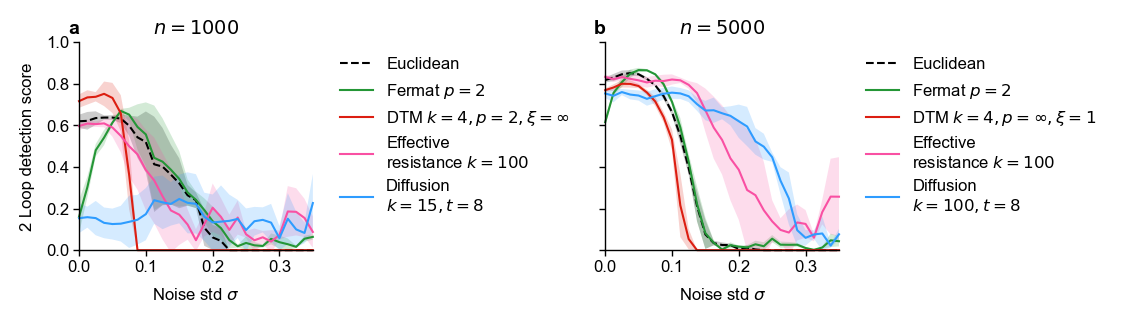

In [11]:
# plot figure
fig, ax = plt.subplots(1, len(nbs), figsize=(5.5, 1.5))
letters = "abcdef"
for i, n in enumerate(nbs):
    for j, dist in enumerate(best_method_per_dataset[n]):
        full_dist = best_method_per_dataset[n][dist]
        #if n == 5000:
        #    mean = outlier_scores[n][dist][full_dist][:,0] 
        #    std = outlier_scores[n][dist][full_dist][:, 0][:, None].std(1)
        #else:
        mean = outlier_scores[n][dist][full_dist].mean(1)
        std = outlier_scores[n][dist][full_dist].std(1)
        
        if dist == "euclidean":
            linestyle = "dashed"
        else:
            linestyle = "solid"
        
        ax[i].plot(sigmas, 
                   mean,
                   label=full_dist_to_print[full_dist],
                   color=dist_to_color[dist],
                   linestyle=linestyle,
                   clip_on=False)
        ax[i].fill_between(
            sigmas,
            mean - std,
            mean + std,
            alpha=0.2,
            color=dist_to_color[dist],
            edgecolor=None,
        )
            
    ax[i].set_ylim(0, 1)
    ax[i].set_xlim(0, sigmas.max())
    ax[i].set_xlabel("Noise std $\sigma$")
    ax[i].set_title(f"$n={n}$")
    
    ax[i].set_title(
        letters[i],
        loc="left",
        ha="right",
        fontweight="bold",
)

for i in range(2):
    #ax[i].legend(loc="upper left", bbox_to_anchor=(0.25, -0.2))
    ax[i].legend(loc="upper left", bbox_to_anchor=(1.05, 1.0))
    if i == 0:
        ax[i].set_ylabel("2 Loop detection score")
    else:
        ax[i].set_yticklabels([])
fig.savefig(os.path.join(fig_path, "torus_vary_n.pdf"))

# Investigate poor performance of diffusion (and Fermat at low noise levels)

## plot all hyperparams

In [380]:
from utils.fig_utils import  full_dist_to_print, dist_to_color, full_dist_to_color

In [ ]:
# hyperparameters

nbs = [1000, 5000]

distances = {
    "euclidean": [{}],
    #"fermat": [
    #    {"p": 2},
    #    {"p": 3},
    #    {"p": 5},
    #    {"p": 7}
    #    ],
    #"dtm": [
    #        {"k": 4, "p_dtm": 2, "p_radius": 1},
    #        {"k": 4, "p_dtm": np.inf, "p_radius": 1},
    #        {"k": 15, "p_dtm": 2, "p_radius": 1},
    #        {"k": 15, "p_dtm": np.inf, "p_radius": 1},
    #        {"k": 100, "p_dtm": 2, "p_radius": 1},
    #        {"k": 100, "p_dtm": np.inf, "p_radius": 1},
    #        {"k": 4, "p_dtm": 2, "p_radius": 2},
    #        {"k": 4, "p_dtm": np.inf, "p_radius": 2},
    #        {"k": 15, "p_dtm": 2, "p_radius": 2},
    #        {"k": 15, "p_dtm": np.inf, "p_radius": 2},
    #        {"k": 100, "p_dtm": 2, "p_radius": 2},
    #        {"k": 100, "p_dtm": np.inf, "p_radius": 2},
    #        {"k": 4, "p_dtm": 2, "p_radius": np.inf},
    #        {"k": 4, "p_dtm": np.inf, "p_radius": np.inf},
    #        {"k": 15, "p_dtm": 2, "p_radius": np.inf},
    #        {"k": 15, "p_dtm": np.inf, "p_radius": np.inf},
    #        {"k": 100, "p_dtm": 2, "p_radius": np.inf},
    #        {"k": 100, "p_dtm": np.inf, "p_radius": np.inf},
    #],
    "eff_res": [
        {"corrected": True, "weighted": False, "k": 15, "disconnect": True},
        {"corrected": True, "weighted": False, "k": 100, "disconnect": True,}
    ],
    "diffusion": [
        {"k": 15, "t": 8, "kernel": "sknn", "include_self": False},
        {"k": 100, "t": 8, "kernel": "sknn", "include_self": False},
        {"k": 15, "t": 64, "kernel": "sknn", "include_self": False},
        {"k": 100, "t": 64, "kernel": "sknn", "include_self": False},
    ],
}


In [ ]:
# load PH results
all_res_50 = {}
for n in nbs:
    all_res_50[n] = load_multiple_res(datasets=dataset, n=n, embd_dims=d, distances=distances, sigmas=sigmas, seeds=seeds, root_path=root_path, n_threads=10)

In [ ]:
# thresholding
dob = 1.25
for n in all_res_50:
    all_res_50[n] = filter_dgms(dgms=all_res_50[n], dob=dob, binary=True, dim=1)

In [ ]:
# compute detection scores
outlier_scores = {}
for n in nbs:
    outlier_scores[n] = compute_outlier_scores(all_res_50[n], 
                                            n_features=2, 
                                            dim=1)

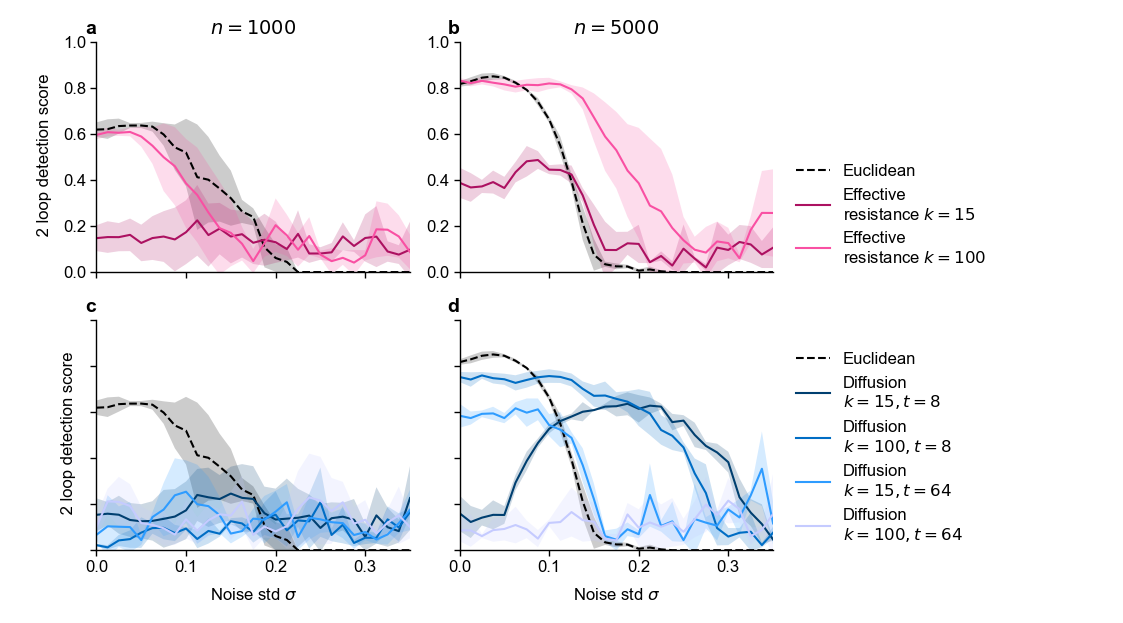

In [386]:
fig, ax = plt.subplots(2,  3, figsize=(5.5, 3))
letters = "abcdef"

for j, n in enumerate(nbs):





    for i, dist in enumerate(["eff_res", "diffusion"]):
        cax = ax[i, j]

         # plot euclidean as reference
        full_dist = best_method_per_dataset[n]["euclidean"]
        mean = outlier_scores[n]["euclidean"][full_dist].mean(1)
        std = outlier_scores[n]["euclidean"][full_dist].std(1)
        cax.plot(sigmas, mean, label=full_dist_to_print[full_dist], color=dist_to_color["euclidean"], linestyle="dashed")
        cax.fill_between(
            sigmas,
            mean - std,
            mean + std,
            alpha=0.2,
            color=dist_to_color["euclidean"],
            edgecolor=None,
        )


        for full_dist in outlier_scores[n][dist]:
            mean = outlier_scores[n][dist][full_dist].mean(1)
            std = outlier_scores[n][dist][full_dist].std(1)

            cax.plot(sigmas, mean, label=full_dist_to_print[full_dist], color=full_dist_to_color[full_dist])
            cax.fill_between(
                sigmas,
                mean - std,
                mean + std,
                alpha=0.2,
                color=full_dist_to_color[full_dist],
                edgecolor=None,
            )
        cax.set_ylim(0, 1)
        cax.set_xlim(0, sigmas.max())
        cax.set_xlabel("Noise std $\sigma$")
        cax.set_title(
            letters[i*2 + j],
            loc="left",
            ha="right",
            fontweight="bold",
        )
        if j == 0:
            ax[i, j].set_ylabel(f"\n 2 loop detection score")
        if i == 0:
            ax[i, j].set_title(f"$n={n}$")
            ax[i, j].set_xlabel("")
            ax[i, j].set_xticklabels([])
        else:
            ax[i, j].set_yticklabels([])

for i in range(2):
    handles, labels = ax[i, 0].get_legend_handles_labels()
    egend = ax[i, -1].legend(loc=(0.0, 0.0),
                                  ncols=1,
                                  handles=handles,
                                  frameon=False
                                  )
    ax[i, -1].axis("off")

fig.savefig(os.path.join(fig_path, "torus_vary_n_all_hyper.png"))

# more diff times

In [10]:
from utils.fig_utils import dist_to_print, full_dist_to_print, dist_to_color, full_dist_to_color


In [11]:
# hyperparameters

nbs = [1000]



distances = {
    "euclidean": [{}],
    #"fermat": [
    #    {"p": 2},
    #    {"p": 3},
    #    {"p": 5},
    #    {"p": 7}
    #    ],
    #"dtm": [
    #        {"k": 4, "p_dtm": 2, "p_radius": 1},
    #        {"k": 4, "p_dtm": np.inf, "p_radius": 1},
    #        {"k": 15, "p_dtm": 2, "p_radius": 1},
    #        {"k": 15, "p_dtm": np.inf, "p_radius": 1},
    #        {"k": 100, "p_dtm": 2, "p_radius": 1},
    #        {"k": 100, "p_dtm": np.inf, "p_radius": 1},
    #        {"k": 4, "p_dtm": 2, "p_radius": 2},
    #        {"k": 4, "p_dtm": np.inf, "p_radius": 2},
    #        {"k": 15, "p_dtm": 2, "p_radius": 2},
    #        {"k": 15, "p_dtm": np.inf, "p_radius": 2},
    #        {"k": 100, "p_dtm": 2, "p_radius": 2},
    #        {"k": 100, "p_dtm": np.inf, "p_radius": 2},
    #        {"k": 4, "p_dtm": 2, "p_radius": np.inf},
    #        {"k": 4, "p_dtm": np.inf, "p_radius": np.inf},
    #        {"k": 15, "p_dtm": 2, "p_radius": np.inf},
    #        {"k": 15, "p_dtm": np.inf, "p_radius": np.inf},
    #        {"k": 100, "p_dtm": 2, "p_radius": np.inf},
    #        {"k": 100, "p_dtm": np.inf, "p_radius": np.inf},
    #],
    #"eff_res": [
    #    {"corrected": True, "weighted": False, "k": 15, "disconnect": True},
    #    {"corrected": True, "weighted": False, "k": 100, "disconnect": True,}
    #],
    "diffusion": [
        {"k": 15, "t": 2, "kernel": "sknn", "include_self": False},
        {"k": 15, "t": 4, "kernel": "sknn", "include_self": False},
        {"k": 15, "t": 8, "kernel": "sknn", "include_self": False},
        {"k": 15, "t": 16, "kernel": "sknn", "include_self": False},
        {"k": 15, "t": 32, "kernel": "sknn", "include_self": False},
        {"k": 15, "t": 64, "kernel": "sknn", "include_self": False},
        {"k": 100, "t": 2, "kernel": "sknn", "include_self": False},
        {"k": 100, "t": 4, "kernel": "sknn", "include_self": False},
        {"k": 100, "t": 8, "kernel": "sknn", "include_self": False},
        {"k": 100, "t": 16, "kernel": "sknn", "include_self": False},
        {"k": 100, "t": 32, "kernel": "sknn", "include_self": False},
        {"k": 100, "t": 64, "kernel": "sknn", "include_self": False},
    ],
}


In [12]:
# load PH results
all_res_50 = {}
for n in nbs:
    all_res_50[n] = load_multiple_res(datasets=dataset, n=n, embd_dims=d, distances=distances, sigmas=sigmas, seeds=seeds, root_path=root_path, n_threads=10)

Done with torus 50 euclidean n_outliers=0, perturbation=None
Done with torus 50 diffusion_k_15_t_2_kernel_sknn_include_self_False n_outliers=0, perturbation=None
Done with torus 50 diffusion_k_100_t_2_kernel_sknn_include_self_False n_outliers=0, perturbation=None
Done with torus 50 diffusion_k_15_t_4_kernel_sknn_include_self_False n_outliers=0, perturbation=None
Done with torus 50 diffusion_k_100_t_4_kernel_sknn_include_self_False n_outliers=0, perturbation=None
Done with torus 50 diffusion_k_15_t_8_kernel_sknn_include_self_False n_outliers=0, perturbation=None
Done with torus 50 diffusion_k_100_t_8_kernel_sknn_include_self_False n_outliers=0, perturbation=None
Done with torus 50 diffusion_k_15_t_16_kernel_sknn_include_self_False n_outliers=0, perturbation=None
Done with torus 50 diffusion_k_100_t_16_kernel_sknn_include_self_False n_outliers=0, perturbation=None
Done with torus 50 diffusion_k_15_t_64_kernel_sknn_include_self_False n_outliers=0, perturbation=None
Done with torus 50 diff

In [13]:
# thresholding
dob = 1.25
for n in all_res_50:
    all_res_50[n] = filter_dgms(dgms=all_res_50[n], dob=dob, binary=True, dim=1)

In [14]:
# compute detection scores
outlier_scores = {}
for n in nbs:
    outlier_scores[n] = compute_outlier_scores(all_res_50[n], 
                                            n_features=2, 
                                            dim=1)

In [18]:
import glasbey

n_diff = len(list(outlier_scores[nbs[0]]["diffusion"].keys))
block_sizes = [n_diff // 2, n_diff //2]
colors = glasbey.create_block_palette(block_sizes)
for i, full_dist in enumerate(outlier_scores[nbs[0]]["diffusion"]):
    full_dist_to_color[full_dist] = colors[i]

        

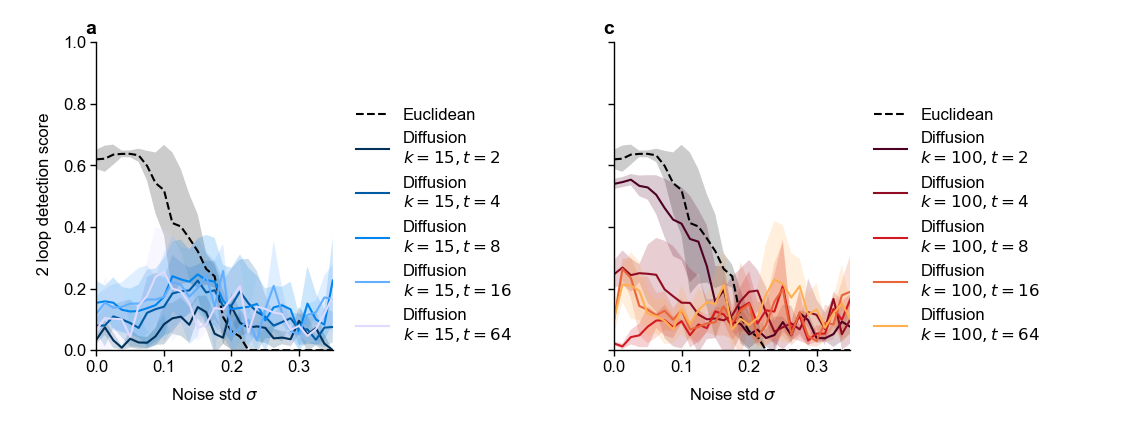

In [23]:
fig, ax = plt.subplots(ncols=4, figsize=(5.5, 2))
letters = "abcdef"

n = 1000
dist = "diffusion"

for i in range(2):
    cax = ax[2*i]


    # plot euclidean as reference
    full_dist = "euclidean"
    mean = outlier_scores[n]["euclidean"][full_dist].mean(1)
    std = outlier_scores[n]["euclidean"][full_dist].std(1)
    cax.plot(sigmas, mean, label=full_dist_to_print[full_dist], color=dist_to_color["euclidean"], linestyle="dashed")
    cax.fill_between(
        sigmas,
        mean - std,
        mean + std,
        alpha=0.2,
        color=dist_to_color["euclidean"],
        edgecolor=None,
    )

    for full_dist in outlier_scores[n]["diffusion"]:
        if ("k_100" in full_dist)==i:
            
            mean = outlier_scores[n][dist][full_dist].mean(1)
            std = outlier_scores[n][dist][full_dist].std(1)

            cax.plot(sigmas, mean, label=full_dist_to_print[full_dist], color=full_dist_to_color[full_dist])
            cax.fill_between(
                sigmas,
                mean - std,
                mean + std,
                alpha=0.2,
                color=full_dist_to_color[full_dist],
                edgecolor=None,
            )
    cax.set_ylim(0, 1)
    cax.set_xlim(0, sigmas.max())
    cax.set_xlabel("Noise std $\sigma$")
    cax.set_title(
        letters[i*2],
        loc="left",
        ha="right",
        fontweight="bold",
    )

    if i == 0:
        cax.set_ylabel(f"\n 2 loop detection score")
    else:
        cax.set_yticklabels([])

for i in range(2):
    handles, labels = ax[2*i].get_legend_handles_labels()
    egend = ax[2*i+1].legend(loc=(0.0, 0.0),
                                  ncols=1,
                                  handles=handles,
                                  frameon=False
                                  )
    ax[2*i+1].axis("off")

fig.savefig(os.path.join(fig_path, "torus_more_diffusion_t.png"))

## plot PDs and representatives

In [15]:
from utils.toydata_utils import get_toy_data
from utils.fig_utils import plot_dgm_loops
from sklearn.decomposition import PCA

In [123]:
dataset = "torus"
d=50
sigma = 0.0

n=5000
pca = PCA(n_components=3)

data = {sigma: {seed: get_toy_data(n=n, dataset=dataset, d=d, seed=seed, **{"gaussian": {"sigma": sigma}}) for seed in seeds} for sigma in sigmas}
embd = {sigma: {seed: pca.fit_transform(data[sigma][seed]) for seed in seeds} for sigma in sigmas}

In [124]:
seed = 0

(<Figure size 4000x800 with 5 Axes>,
 array([<Axes: label='00', xlabel='Birth', ylabel='Death'>,
        <Axes3D: label='10'>, <Axes3D: label='20'>, <Axes3D: label='30'>,
        <Axes3D: label='40'>], dtype=object))

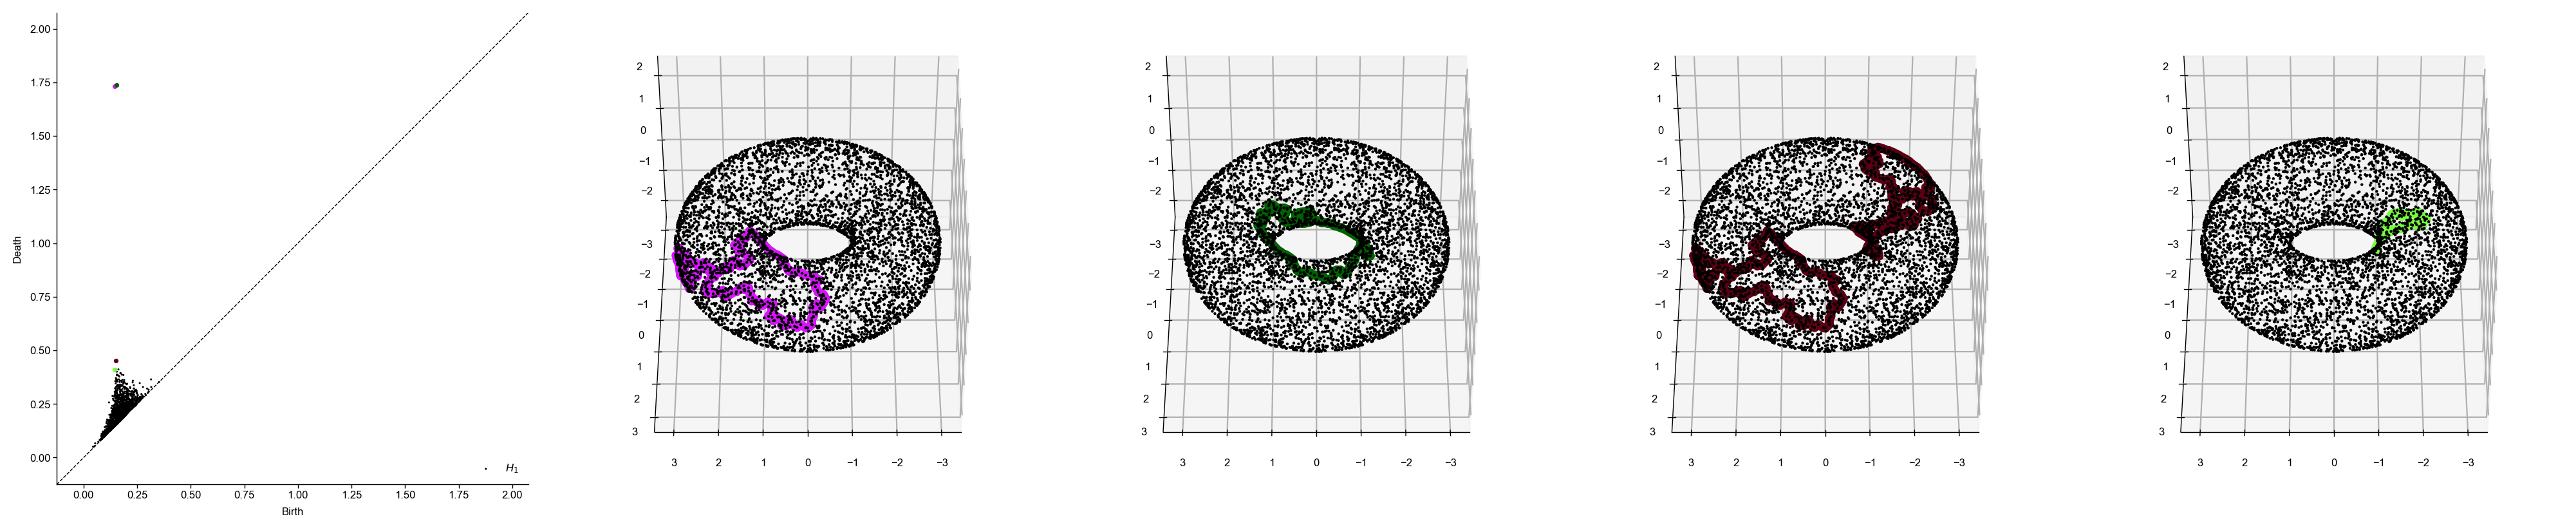

In [126]:
plot_dgm_loops(res=all_res_50[n]["euclidean"]["euclidean"][sigma][seed],
               embd=embd[sigma][seed],
                y="k",
                   n_loops=4,
                   n_cols=5,
                   cmap="tab20",
                   plot_only=[1],
                   s=10,
                   #colors=["k", dist_to_color["fermat"]],
                   confidence=None,
                   #ax=ax,
                   linewidth=5,
                   style=style_file,
                   plot_loops=True,
                   )

eff_res_corrected_True_weighted_False_k_100_disconnect_True


(<Figure size 4000x800 with 5 Axes>,
 array([<Axes: label='00', xlabel='Birth', ylabel='Death'>,
        <Axes3D: label='10'>, <Axes3D: label='20'>, <Axes3D: label='30'>,
        <Axes3D: label='40'>], dtype=object))

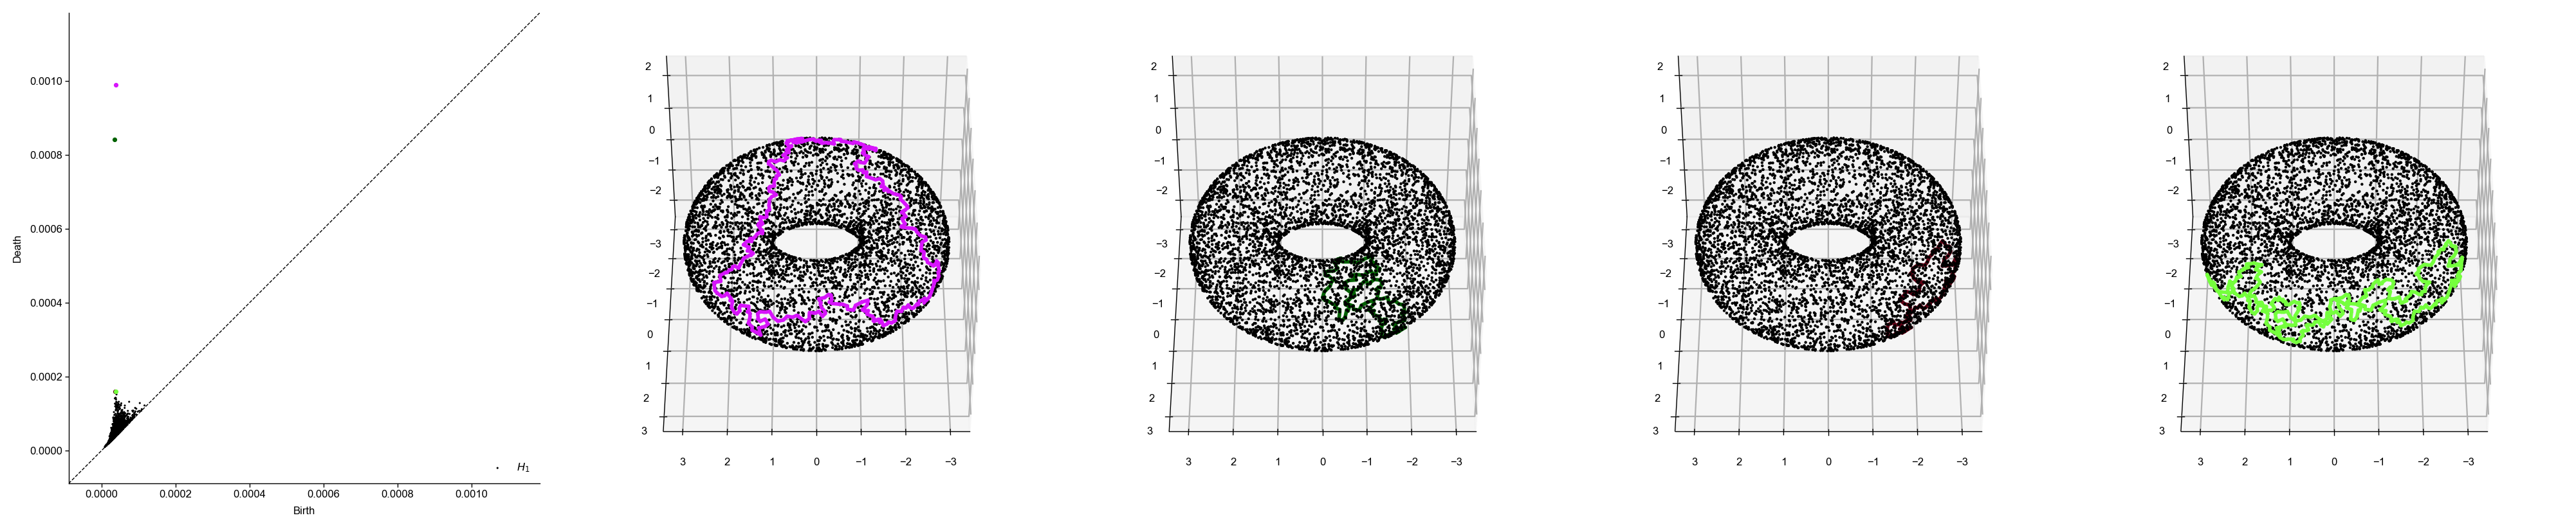

In [127]:
full_dist = best_method_per_dataset[n]["eff_res"]
print(full_dist)
plot_dgm_loops(res=all_res_50[n]["eff_res"][full_dist][sigma][seed],
               embd=embd[sigma][seed],
                y="k",
                   n_loops=4,
                   n_cols=5,
                   cmap="tab20",
                   plot_only=[1],
                   s=10,
                   #colors=["k", dist_to_color["fermat"]],
                   confidence=None,
                   #ax=ax,
                   linewidth=2,
                   style=style_file,
                   plot_loops=True,
                   )

eff_res_corrected_True_weighted_False_k_100_disconnect_True


(<Figure size 4000x800 with 5 Axes>,
 array([<Axes: label='00', xlabel='Birth', ylabel='Death'>,
        <Axes3D: label='10'>, <Axes3D: label='20'>, <Axes3D: label='30'>,
        <Axes3D: label='40'>], dtype=object))

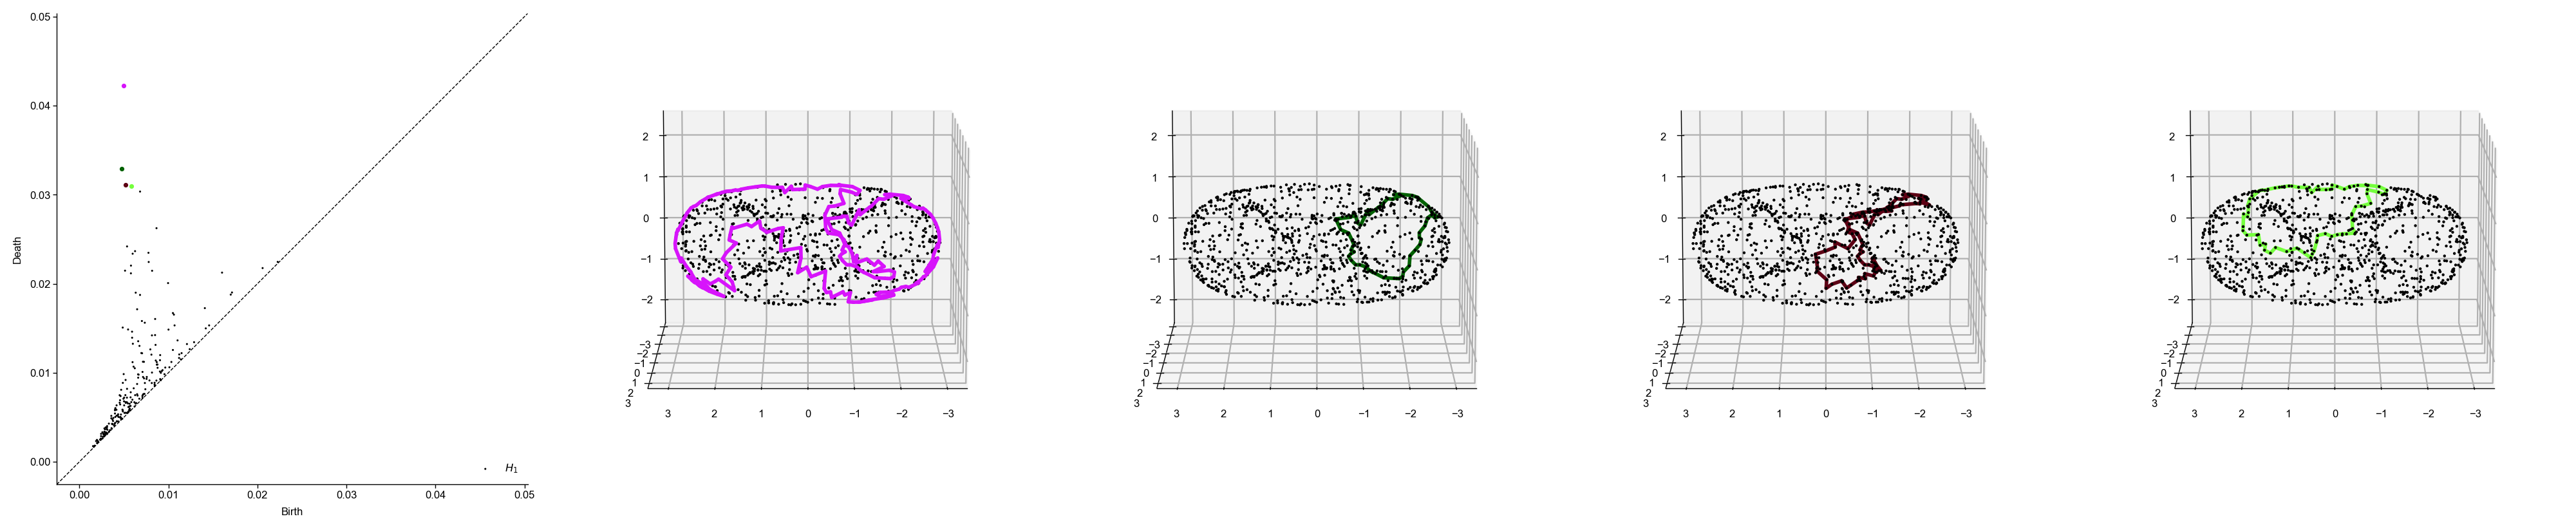

In [119]:

full_dist = best_method_per_dataset[n]["eff_res"]
print(full_dist)
plot_dgm_loops(res=all_res_50[n]["eff_res"]["eff_res_corrected_True_weighted_False_k_15_disconnect_True"][sigma][seed],
               embd=embd[sigma][seed],
                y="k",
                   n_loops=4,
                   n_cols=5,
                   cmap="tab20",
                   plot_only=[1],
                   s=10,
                   #colors=["k", dist_to_color["fermat"]],
                   confidence=None,
                   #ax=ax,
                   linewidth=2,
                   style=style_file,
                   plot_loops=True,
               elev=10,
               azim=-90
                   )

fermat_p_2


(<Figure size 4000x800 with 5 Axes>,
 array([<Axes: label='00', xlabel='Birth', ylabel='Death'>,
        <Axes3D: label='10'>, <Axes3D: label='20'>, <Axes3D: label='30'>,
        <Axes3D: label='40'>], dtype=object))

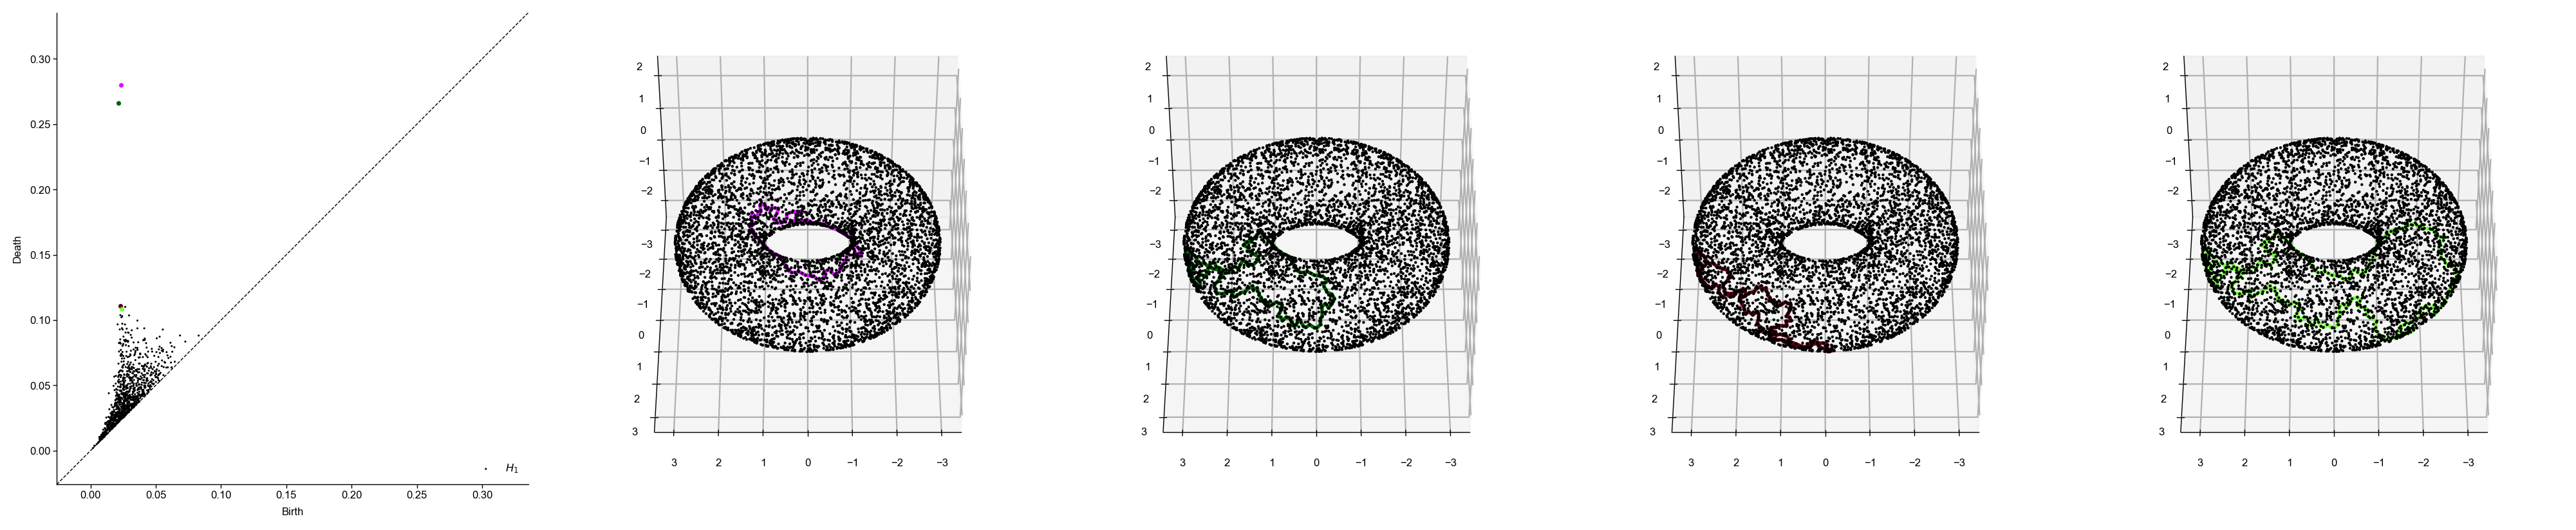

In [128]:
full_dist = best_method_per_dataset[n]["fermat"]
print(full_dist)
plot_dgm_loops(res=all_res_50[n]["fermat"][full_dist][sigma][seed],
               embd=embd[sigma][seed],
                y="k",
                   n_loops=4,
                   n_cols=5,
                   cmap="tab20",
                   plot_only=[1],
                   s=10,
                   #colors=["k", dist_to_color["fermat"]],
                   confidence=None,
                   #ax=ax,
                   linewidth=2,
                   style=style_file,
                   plot_loops=True,
               elev=45
                   )

diffusion_k_100_t_8_kernel_sknn_include_self_False


(<Figure size 4000x800 with 5 Axes>,
 array([<Axes: label='00', xlabel='Birth', ylabel='Death'>,
        <Axes3D: label='10'>, <Axes3D: label='20'>, <Axes3D: label='30'>,
        <Axes3D: label='40'>], dtype=object))

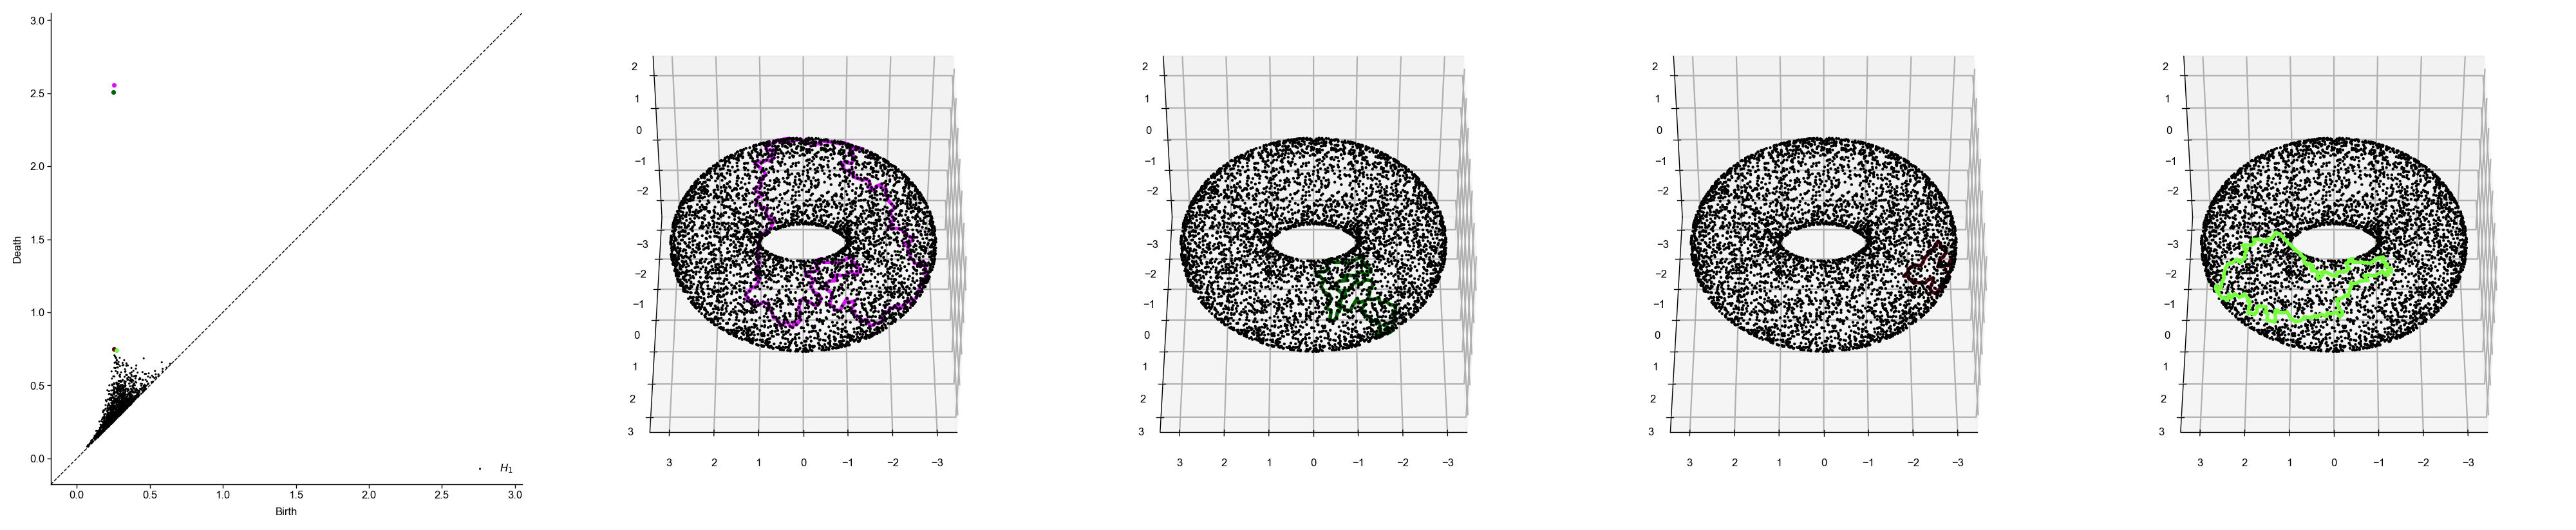

In [129]:
distance = "diffusion"
full_dist = best_method_per_dataset[n][distance]
print(full_dist)
plot_dgm_loops(res=all_res_50[n][distance][full_dist][sigma][seed],
               embd=embd[sigma][seed],
                y="k",
                   n_loops=4,
                   n_cols=5,
                   cmap="tab20",
                   plot_only=[1],
                   s=10,
                   #colors=["k", dist_to_color["fermat"]],
                   confidence=None,
                   #ax=ax,
                   linewidth=2,
                   style=style_file,
                   plot_loops=True,
               elev=45
                   )

(<Figure size 4000x800 with 5 Axes>,
 array([<Axes: label='00', xlabel='Birth', ylabel='Death'>,
        <Axes3D: label='10'>, <Axes3D: label='20'>, <Axes3D: label='30'>,
        <Axes3D: label='40'>], dtype=object))

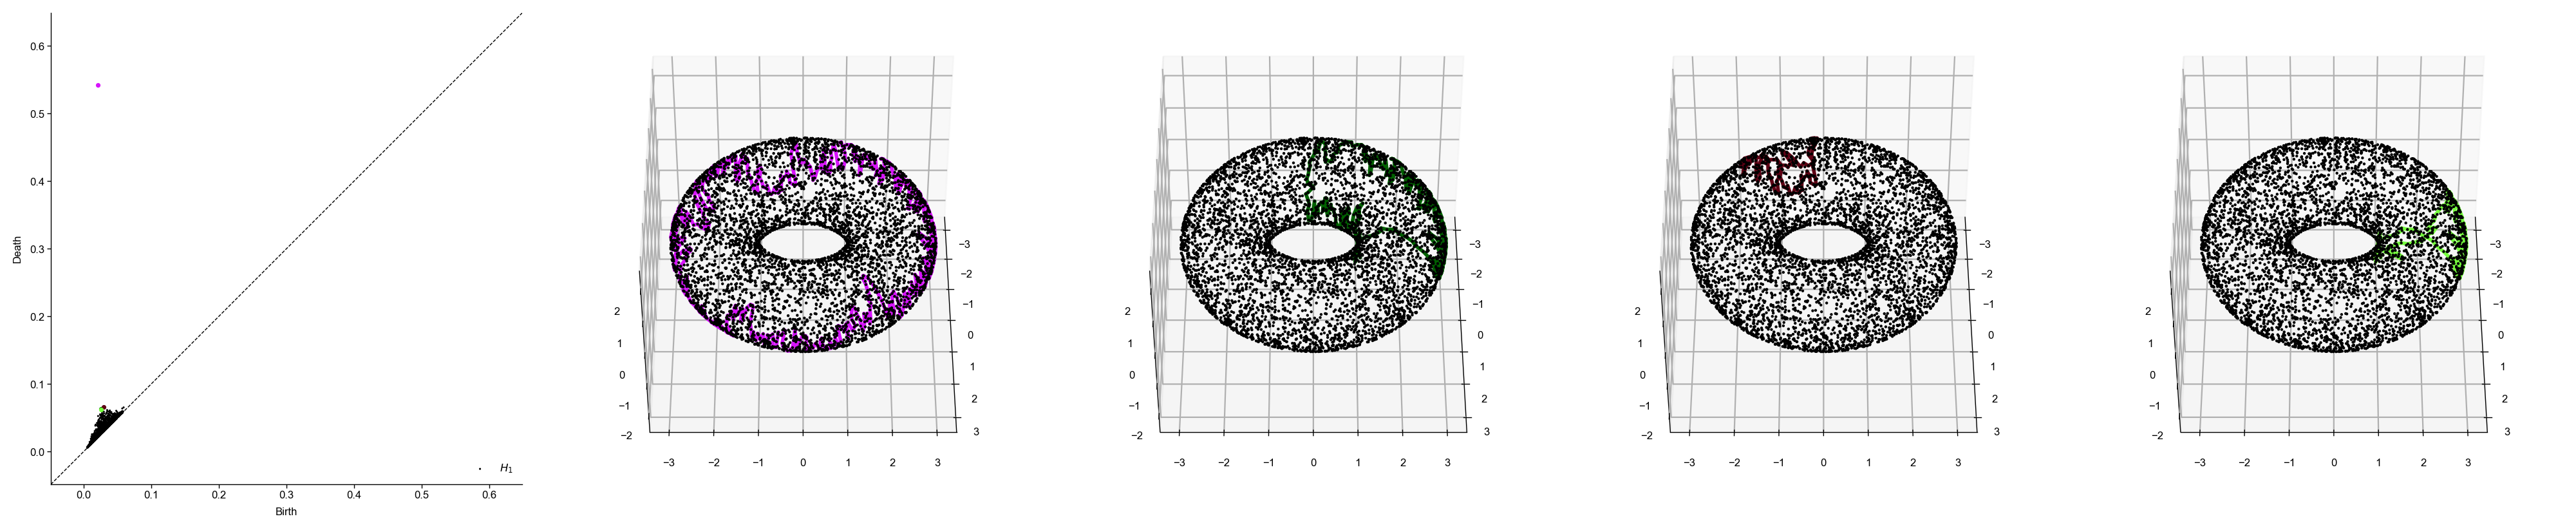

In [131]:

distance = "diffusion"

k=100
t=64

plot_dgm_loops(res=all_res_50[n][distance][f"diffusion_k_{k}_t_{t}_kernel_sknn_include_self_False"][sigma][seed],
embd = embd[sigma][seed],
y = "k",
n_loops = 4,
n_cols = 5,
cmap = "tab20",
plot_only = [1],
s = 10,
#colors=["k", dist_to_color["fermat"]],
confidence = None,
#ax=ax,
linewidth = 2,
style = style_file,
plot_loops = True,
elev = 45,
        azim=0
)

## look at eigenvectors etc.

In [24]:
from utils.dist_utils import get_diffusion_dist, get_spectral_diffusion, get_spectral_eff_res

In [25]:
from utils.toydata_utils import invert_torus, get_torus

In [26]:
from utils.utils import eff_res_corr_decay, diffusion_decay
from utils.fig_utils import dist_to_color, full_dist_to_color, full_dist_to_print


In [28]:
def plot_spectrum_torus(phi, theta, eigenvalues, eigenvectors, k, n, ts=None):
    nrows = 2
    ncols = 5

    fig, ax  = plt.subplots(nrows, ncols, figsize=(5.5, 2.75))

    full_dist_eff = f"eff_res_corrected_True_weighted_False_k_{k}_disconnect_True"
    ax[0,0].plot(np.arange(1, n),
                 eff_res_corr_decay(eigenvalues),
                 c=full_dist_to_color[full_dist_eff],
                 label=full_dist_to_print[full_dist_eff])
    
    if ts is None:
        ts = [8, 64]
    for t in ts:
        full_dist_diff = f"diffusion_k_{k}_t_{t}_kernel_sknn_include_self_False"

        if full_dist_diff not in full_dist_to_color:
            full_dist_to_color[full_dist_diff] = "k"
        ax[0,0].plot(np.arange(1, n),
                     diffusion_decay(eigenvalues, t=t),
                     c=full_dist_to_color[full_dist_diff],
                     label=full_dist_to_print[full_dist_diff])
    

    ax[0,0].set_xscale("log")
    ax[0,0].set_xticks([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 100, 1000], ["1", "2", "3", "", "", "", "", "", "", "10", "100", "1000"])

    ax[0, 0]. set_xlabel("Eigenvalue index")
    ax[0, 0].set_ylabel("Eigenvalue")
    ax[0, 0].set_title("Spectral decay")

    handles, labels = ax[0, 0].get_legend_handles_labels()
    legend = ax[1, 0].legend(loc=(0.0, 0.0),
                                  ncols=1,
                                  handles=handles,
                                  frameon=False
                                  )

    ax[1, 0].axis("off")
    for i in range(nrows):
        for j in range(ncols-1):
            ev_ind = j*nrows + i
            cax = ax[i, j+1]
            cax.scatter(phi, theta, s=1, c=eigenvectors[:, ev_ind], cmap="viridis")
            cax.set_aspect("equal")
            cax.set_xticks([0, np.pi/2, np.pi, 3*np.pi/2, 2*np.pi], ["0", "$\pi/2$", "$\pi$", "$3\pi/2$", "$2\pi$"])
            cax.set_yticks([0, np.pi/2, np.pi, 3*np.pi/2, 2*np.pi], ["0", "$\pi/2$", "$\pi$", "$3\pi/2$", "$2\pi$"])
            if j == 0:
                cax.set_ylabel("$\\theta$")
            else:
                cax.set_yticklabels([])

            if i == 0:
                cax.set_xticklabels([])
            else:
                cax.set_xlabel("$\phi$")
            cax.set_title(f"Eigenvector {ev_ind+1}")

    return fig, ax

In [30]:
seed =0 

In [ ]:
n = 1000
k= 100

torus, phi, theta = get_torus(n=n, seed=seed+1, r=1.0, return_angles=True)

_, _, eigenvalues, eigenvectors = get_spectral_diffusion(torus, k=k, t=8, kernel="sknn", include_self=False, return_embd=True, return_spectrum=True)

fig, ax = plot_spectrum_torus(phi, theta, eigenvalues, eigenvectors, k=k, n=n, ts=[2, 8, 64])
fig.suptitle(f"Torus $n={n}$, $k={k}$, uniform sampling")
fig.savefig(os.path.join(fig_path, f"torus_spectrum_n_{n}_k_{k}.png"))

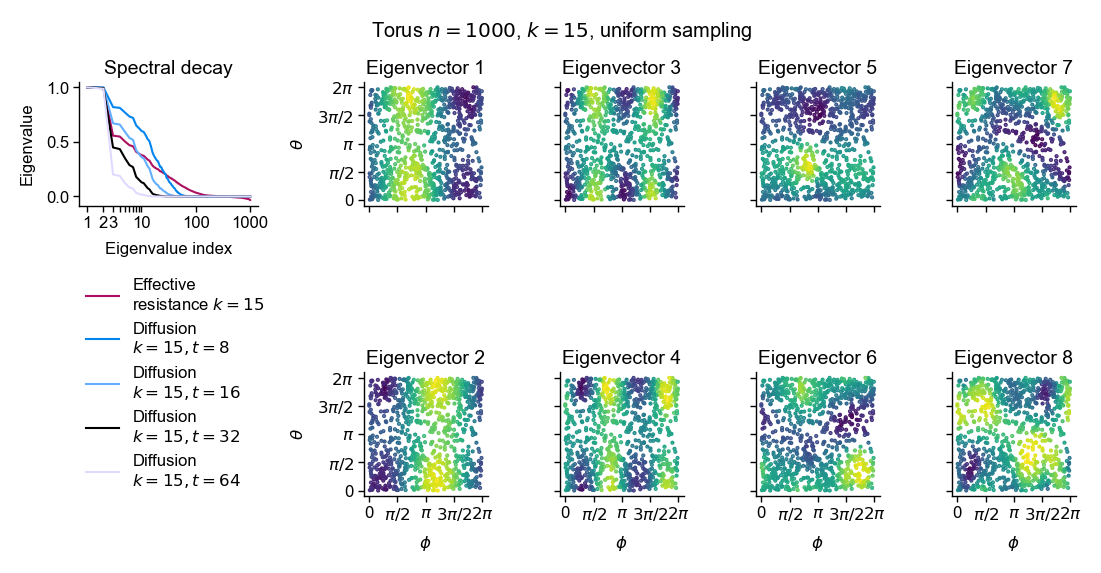

In [33]:
n = 1000
k= 15

torus, phi, theta = get_torus(n=n, seed=seed+1, r=1.0, return_angles=True)

_, _, eigenvalues, eigenvectors = get_spectral_diffusion(torus, k=k, t=8, kernel="sknn", include_self=False, return_embd=True, return_spectrum=True)

fig, ax = plot_spectrum_torus(phi, theta, eigenvalues, eigenvectors, k=k, n=n, ts=[8, 16, 32, 64])
fig.suptitle(f"Torus $n={n}$, $k={k}$, uniform sampling")
fig.savefig(os.path.join(fig_path, f"torus_spectrum_n_{n}_k_{k}.png"))

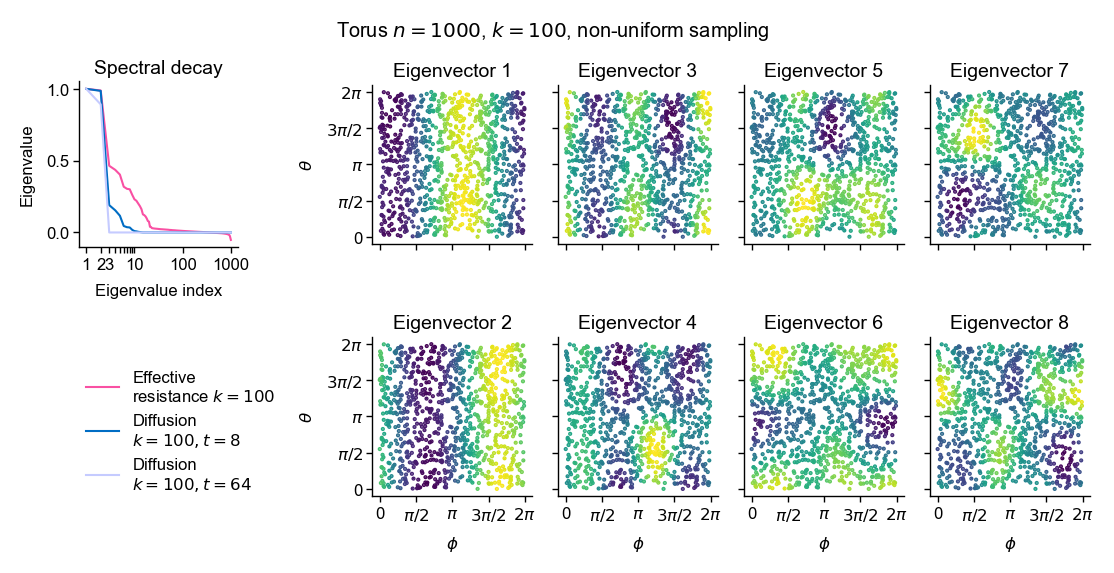

In [363]:
n = 1000
k= 100

torus, phi, theta = get_torus(n=n, seed=seed+1, r=1.0, return_angles=True, uniform=False)

_, _, eigenvalues, eigenvectors = get_spectral_diffusion(torus, k=k, t=8, kernel="sknn", include_self=False, return_embd=True, return_spectrum=True)

fig, ax = plot_spectrum_torus(phi, theta, eigenvalues, eigenvectors, k=k, n=n)
fig.suptitle(f"Torus $n={n}$, $k={k}$, non-uniform sampling")
fig.savefig(os.path.join(fig_path, f"torus_spectrum_n_{n}_k_{k}_non_uniform.png"))

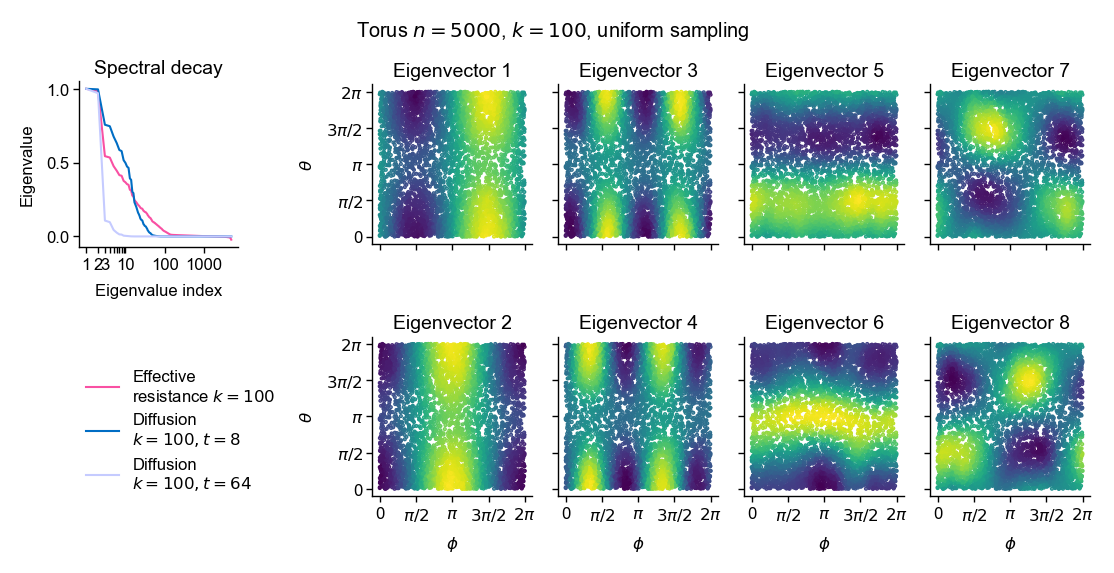

In [364]:
n = 5000
k= 100

torus, phi, theta = get_torus(n=n, seed=seed+1, r=1.0, return_angles=True)

_, _, eigenvalues, eigenvectors = get_spectral_diffusion(torus, k=k, t=8, kernel="sknn", include_self=False, return_embd=True, return_spectrum=True)

fig, ax = plot_spectrum_torus(phi, theta, eigenvalues, eigenvectors, k=k, n=n)
fig.suptitle(f"Torus $n={n}$, $k={k}$, uniform sampling")
fig.savefig(os.path.join(fig_path, f"torus_spectrum_n_{n}_k_{k}.png"))

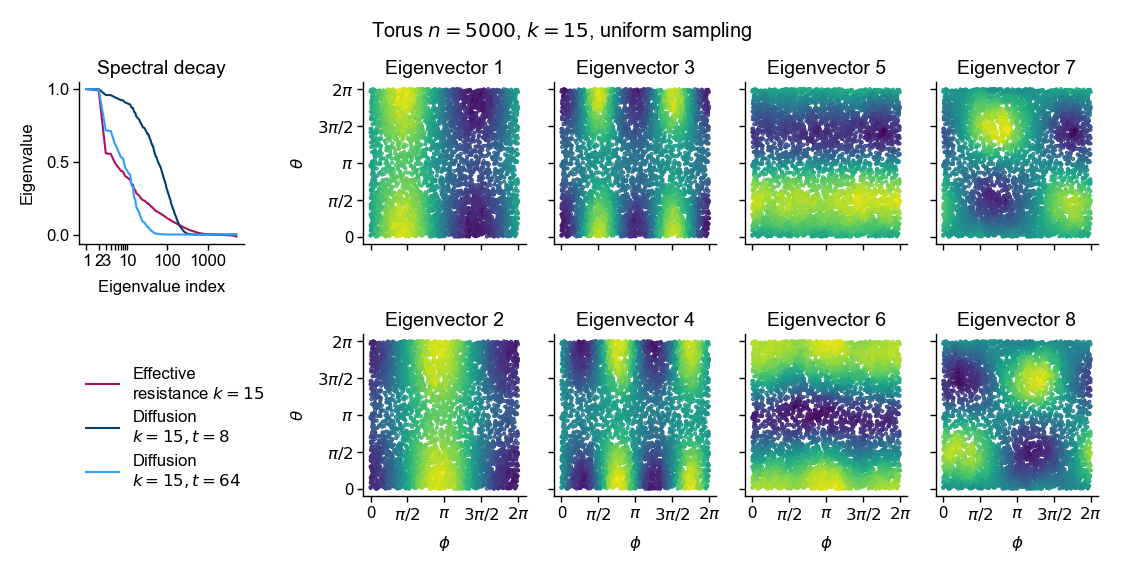

In [365]:
n = 5000
k= 15

torus, phi, theta = get_torus(n=n, seed=seed+1, r=1.0, return_angles=True)

_, _, eigenvalues, eigenvectors = get_spectral_diffusion(torus, k=k, t=8, kernel="sknn", include_self=False, return_embd=True, return_spectrum=True)

fig, ax = plot_spectrum_torus(phi, theta, eigenvalues, eigenvectors, k=k, n=n)
fig.suptitle(f"Torus $n={n}$, $k={k}$, uniform sampling")
fig.savefig(os.path.join(fig_path, f"torus_spectrum_n_{n}_k_{k}.png"))

## rebuttal fig

In [14]:
from utils.dist_utils import get_diffusion_dist, get_spectral_diffusion, get_spectral_eff_res
from utils.toydata_utils import invert_torus, get_torus
from utils.utils import eff_res_corr_decay, diffusion_decay
from utils.fig_utils import dist_to_color, full_dist_to_color, full_dist_to_print


In [6]:
from utils.fig_utils import dist_to_print, full_dist_to_print, dist_to_color, full_dist_to_color


In [7]:
# hyperparameters

n=1000


distances = {
    "euclidean": [{}],
    #"fermat": [
    #    {"p": 2},
    #    {"p": 3},
    #    {"p": 5},
    #    {"p": 7}
    #    ],
    #"dtm": [
    #        {"k": 4, "p_dtm": 2, "p_radius": 1},
    #        {"k": 4, "p_dtm": np.inf, "p_radius": 1},
    #        {"k": 15, "p_dtm": 2, "p_radius": 1},
    #        {"k": 15, "p_dtm": np.inf, "p_radius": 1},
    #        {"k": 100, "p_dtm": 2, "p_radius": 1},
    #        {"k": 100, "p_dtm": np.inf, "p_radius": 1},
    #        {"k": 4, "p_dtm": 2, "p_radius": 2},
    #        {"k": 4, "p_dtm": np.inf, "p_radius": 2},
    #        {"k": 15, "p_dtm": 2, "p_radius": 2},
    #        {"k": 15, "p_dtm": np.inf, "p_radius": 2},
    #        {"k": 100, "p_dtm": 2, "p_radius": 2},
    #        {"k": 100, "p_dtm": np.inf, "p_radius": 2},
    #        {"k": 4, "p_dtm": 2, "p_radius": np.inf},
    #        {"k": 4, "p_dtm": np.inf, "p_radius": np.inf},
    #        {"k": 15, "p_dtm": 2, "p_radius": np.inf},
    #        {"k": 15, "p_dtm": np.inf, "p_radius": np.inf},
    #        {"k": 100, "p_dtm": 2, "p_radius": np.inf},
    #        {"k": 100, "p_dtm": np.inf, "p_radius": np.inf},
    #],
    "eff_res": [
        #{"corrected": True, "weighted": False, "k": 15, "disconnect": True},
        {"corrected": True, "weighted": False, "k": 100, "disconnect": True,}
    ],
    "diffusion": [
        #{"k": 15, "t": 2, "kernel": "sknn", "include_self": False},
        #{"k": 15, "t": 4, "kernel": "sknn", "include_self": False},
        #{"k": 15, "t": 8, "kernel": "sknn", "include_self": False},
        #{"k": 15, "t": 16, "kernel": "sknn", "include_self": False},
        #{"k": 15, "t": 32, "kernel": "sknn", "include_self": False},
        #{"k": 15, "t": 64, "kernel": "sknn", "include_self": False},
        {"k": 100, "t": 2, "kernel": "sknn", "include_self": False},
        #{"k": 100, "t": 4, "kernel": "sknn", "include_self": False},
        {"k": 100, "t": 8, "kernel": "sknn", "include_self": False},
        #{"k": 100, "t": 16, "kernel": "sknn", "include_self": False},
        #{"k": 100, "t": 32, "kernel": "sknn", "include_self": False},
        {"k": 100, "t": 64, "kernel": "sknn", "include_self": False},
    ],
}


In [8]:
# load PH results
all_res_50 = load_multiple_res(datasets=dataset, n=n, embd_dims=d, distances=distances, sigmas=sigmas, seeds=seeds, root_path=root_path, n_threads=10)

Done with torus 50 euclidean n_outliers=0, perturbation=None
Done with torus 50 eff_res_corrected_True_weighted_False_k_100_disconnect_True n_outliers=0, perturbation=None
Done with torus 50 diffusion_k_100_t_2_kernel_sknn_include_self_False n_outliers=0, perturbation=None
Done with torus 50 diffusion_k_100_t_8_kernel_sknn_include_self_False n_outliers=0, perturbation=None
Done with torus 50 diffusion_k_100_t_64_kernel_sknn_include_self_False n_outliers=0, perturbation=None


In [9]:
# thresholding
dob = 1.25
all_res_50 = filter_dgms(dgms=all_res_50, dob=dob, binary=True, dim=1)

In [10]:
# compute detection scores
outlier_scores = compute_outlier_scores(all_res_50, n_features=2, dim=1)

In [15]:
seed = 0
k = 100

torus, phi, theta = get_torus(n=n, seed=seed + 1, r=1.0, return_angles=True)

_, _, eigenvalues, eigenvectors = get_spectral_diffusion(torus, k=k, t=8, kernel="sknn", include_self=False,
                                                         return_embd=True, return_spectrum=True)




In [72]:
full_dist_to_color["diffusion_k_100_t_2_kernel_sknn_include_self_False"] =  full_dist_to_color["diffusion_k_15_t_8_kernel_sknn_include_self_False"]

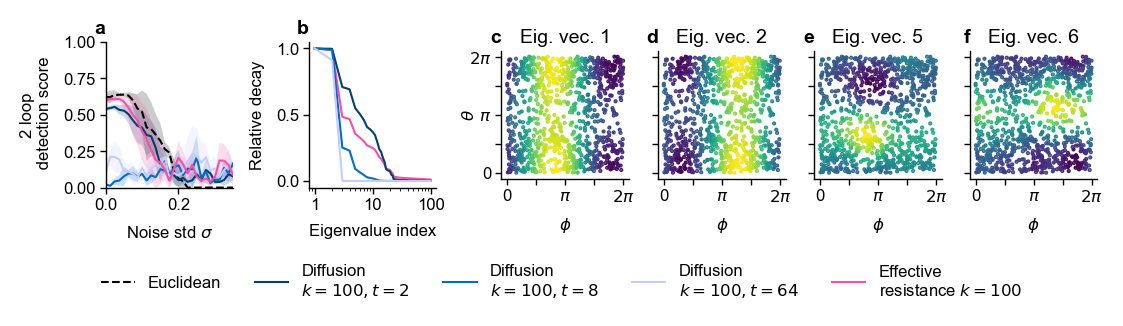

In [79]:

letters  = "abcdef"

mosaic = """
abcdef
"""

fig = plt.figure(figsize=(5.5, 1.5))
f1, f2 = fig.subfigures(2, 1, height_ratios=[1, 0.25])

ax = f1.subplot_mosaic(mosaic)


# plot outlier score

cax = ax["a"]

# plot euclidean as reference
full_dist = "euclidean"
mean = outlier_scores["euclidean"][full_dist].mean(1)
std = outlier_scores["euclidean"][full_dist].std(1)
cax.plot(sigmas, mean, label=full_dist_to_print[full_dist], color=dist_to_color["euclidean"], linestyle="dashed")
cax.fill_between(
    sigmas,
    mean - std,
    mean + std,
    alpha=0.2,
    color=dist_to_color["euclidean"],
    edgecolor=None,
)

for full_dist in outlier_scores["diffusion"]:     
        mean = outlier_scores["diffusion"][full_dist].mean(1)
        std = outlier_scores["diffusion"][full_dist].std(1)

        cax.plot(sigmas, mean, label=full_dist_to_print[full_dist], color=full_dist_to_color[full_dist])
        cax.fill_between(
            sigmas,
            mean - std,
            mean + std,
            alpha=0.2,
            color=full_dist_to_color[full_dist],
            edgecolor=None,
        )
        
# plot eff res 
full_dist = "eff_res_corrected_True_weighted_False_k_100_disconnect_True"
mean = outlier_scores["eff_res"][full_dist].mean(1)
std = outlier_scores["eff_res"][full_dist].std(1)

cax.plot(sigmas, mean, label=full_dist_to_print[full_dist], color=full_dist_to_color[full_dist])
cax.fill_between(
    sigmas,
    mean - std,
    mean + std,
    alpha=0.2,
    color=full_dist_to_color[full_dist],
    edgecolor=None,
)



cax.set_ylim(0, 1)
cax.set_xlim(0, sigmas.max())
cax.set_xlabel("Noise std $\sigma$")
cax.set_title(
    letters[0],
    loc="left",
    ha="right",
    fontweight="bold",
)
#cax.set_title("2 Loop detection")

cax.set_ylabel(f"2 loop\n detection score")

# plot spectral decay
ax["b"].set_title(
    letters[1],
    loc="left",
    ha="right",
    fontweight="bold",
)
max_evec = 100

full_dist_eff = f"eff_res_corrected_True_weighted_False_k_{k}_disconnect_True"
ax["b"].plot(np.arange(1, max_evec+1),
             eff_res_corr_decay(eigenvalues)[:max_evec],
             c=full_dist_to_color[full_dist_eff],
             label=full_dist_to_print[full_dist_eff])

ts = [2, 8, 64]
for t in ts:
    full_dist_diff = f"diffusion_k_{k}_t_{t}_kernel_sknn_include_self_False"

    if full_dist_diff not in full_dist_to_color:
        full_dist_to_color[full_dist_diff] = "k"
    ax["b"].plot(np.arange(1, max_evec+1),
                 diffusion_decay(eigenvalues, t=t)[:max_evec],
                 c=full_dist_to_color[full_dist_diff],
                 label=full_dist_to_print[full_dist_diff])


ax["b"].set_xscale("log")
ax["b"].set_xticks([1, 10, 100], ["1", "10", "100"])
ax["b"].set_xlabel("Eigenvalue index")
ax["b"].set_ylabel("Relative decay")
#ax["b"].set_title("Spectral decay")


# plot legend
handles, labels = ax["a"].get_legend_handles_labels()

ax_leg = f2.subplots()
legend = ax_leg.legend(loc="center",
                              ncols=5,
                              handles=handles,
                              frameon=False
                              )
ax_leg.axis("off")




# plot eigenvectors
evecs_to_plot =[0, 1, 4, 5]

for i in range(4):
    ev_ind = evecs_to_plot[i]
    cax = ax[letters[i+2]]
    cax.scatter(phi, theta, s=1, c=eigenvectors[:, ev_ind], cmap="viridis")
    cax.set_aspect("equal")
    cax.set_xticks([0, np.pi/2, np.pi, 3*np.pi/2, 2*np.pi], ["0", "", "$\pi$", "", "$2\pi$"])
    cax.set_yticks([0, np.pi/2, np.pi, 3*np.pi/2, 2*np.pi], ["0", "", "$\pi$", "", "$2\pi$"])
    if i == 0:
        cax.set_ylabel("$\\theta$", labelpad=-3)
    else:
        cax.set_yticklabels([])

    cax.set_xlabel("$\phi$")
    
    cax.set_title(
        letters[i+2],
        loc="left",
        ha="right",
        fontweight="bold",
    )
    cax.set_title(f"Eig. vec. {ev_ind+1}")

#fig.suptitle(f"Torus $n={n}$, $k={k}$, uniform sampling")
fig.savefig(os.path.join(fig_path, f"torus_spectrum_rebuttal.pdf"))

In [ ]:
"a